In [98]:

import pandas as pd
import numpy as np
import datetime
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
rnd = random.Random( 42 )

In [99]:
base_speed = [ 60, 100, 140 ]
distances = [ 100, 60, 150, 100, 120, 250]
max_cargo = [ 100, 50, 50 ]
last_date = [ datetime.datetime(2022, 1, 1), datetime.datetime(2022, 1, 1), datetime.datetime(2022, 1, 1) ]
load_speed = 15 # seconds per unit of cargo
unload_speed = 10 # seconds per unit of cargo

In [100]:
def calculate_departure( tentative_date, train_id ):
    if tentative_date.weekday() == 6:
        tentative_date += datetime.timedelta( days = 1 )
    if tentative_date.hour > 10 and tentative_date.hour < 16 and train_id == 0:
        tentative_date = tentative_date.replace( hour = 16, minute = 0, second = 0 )
    else: 
        tentative_date = tentative_date.replace( hour = 10, minute = 0, second = 0 )
    while tentative_date in departures_used:
        tentative_date += datetime.timedelta( days = 1 )
        if tentative_date.weekday() == 6:
            tentative_date += datetime.timedelta( days = 1 )
        if tentative_date.hour == 16:
            tentative_date = tentative_date.replace( hour = 10, minute = 0, second = 0 )
    departures_used.add( tentative_date )
    return tentative_date

def generate_cargo( train_id ):
    return rnd.randint( 30, max_cargo[train_id] )

def cargo_deviation():
    return stats.rayleigh.rvs( scale = 0.5 ) / 4 + .85
def travel_deviation():
    return stats.rayleigh.rvs( scale = 0.5 ) / 4 + .85
def load_deviation(train_id, cargo):
    return (max_cargo[train_id] - cargo) / max_cargo[train_id] * 0.25 + 1
    


In [101]:
data = []
departures_used = set()
for i in range( 500 ):
    for train_id in range(3):
        trip_id = "{}_{}".format( train_id, i )
        last_date[train_id] = calculate_departure(last_date[train_id], train_id)
        if last_date[train_id].year > 2022: continue
        data.append( [ trip_id, train_id, last_date[train_id], 0, "station_A", "Comienzo de ruta"] )
        cargo = generate_cargo(train_id)
        if last_date[train_id].weekday() == 5:
            cargo = int(cargo*0.6)
        last_date[train_id] += datetime.timedelta( seconds = int(cargo * load_speed * cargo_deviation()) )
        data.append( [ trip_id, train_id, last_date[train_id], cargo, "station_A", "Final carga"] )
        data.append( [ trip_id, train_id, last_date[train_id], cargo, "station_A", "Salida de vagones"] )

        for station_indx, station_id in enumerate("BCDEFG"):
            last_date[train_id] += datetime.timedelta( seconds = int(3600*distances[station_indx] * travel_deviation() * load_deviation(train_id,cargo) / base_speed[train_id]) )
            data.append( [ trip_id, train_id, last_date[train_id], cargo, "station_{}".format(station_id), "Llegada de vagones" ] )
            unload = rnd.randint( 0, cargo )
            last_date[train_id] += datetime.timedelta( seconds = int(unload * unload_speed * cargo_deviation()) )
            cargo -= unload
            data.append( [ trip_id, train_id, last_date[train_id], cargo, "station_{}".format(station_id), "Descarga de vagones" ] )
            if station_id == "G":
                data.append( [ trip_id, train_id, last_date[train_id], cargo, "station_{}".format(station_id), "Final de ruta" ] )
                last_date[train_id] += datetime.timedelta( seconds = int(3600*sum(distances) * travel_deviation() / base_speed[train_id]) )
            else:
                data.append( [ trip_id, train_id, last_date[train_id], cargo, "station_{}".format(station_id), "Salida de vagones" ] )
df = pd.DataFrame( data, columns = [ "trip_id", "train_id", "date", "cargo", "station_id", "event" ] )

<Axes: >

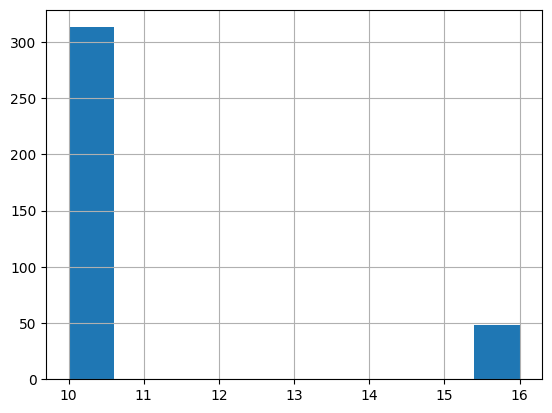

In [102]:
df[df.event== "Comienzo de ruta"].date.dt.hour.hist()

(array([119., 371., 526., 627., 668., 618., 581., 436., 372., 254., 173.,
        104.,  70.,  28.,  27.,   8.,  11.,   4.,   1.,   2.]),
 array([0.85087013, 0.87864103, 0.90641194, 0.93418285, 0.96195376,
        0.98972467, 1.01749558, 1.04526649, 1.0730374 , 1.10080831,
        1.12857922, 1.15635013, 1.18412104, 1.21189195, 1.23966286,
        1.26743377, 1.29520468, 1.32297559, 1.3507465 , 1.37851741,
        1.40628832]),
 <BarContainer object of 20 artists>)

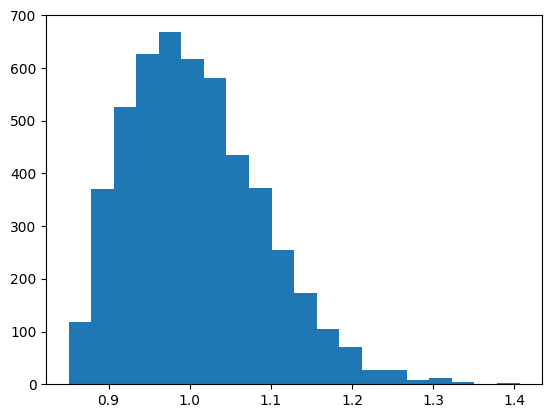

In [104]:
tst = [cargo_deviation() for i in range(5000)]
# print distribution
plt.hist( tst, bins = 20 )

# Questions

- How many records are there in the dataset?
- How many columns are there in the dataset?

---

- How many trains are there in the dataset?
- How many stations are there in the dataset?
- How many trips are there in the dataset?

---

- How many packages were transported in total?
- How many packages were transported in average per train?
- What was the maximum number of packages transported in a train?
- What was the minimum number of packages transported in a train?
- What was the average number of packages transported in a train?

---

- Which train transported the most packages?
- Which train transported the least packages?
- Which train made more trips?
- Which train made less trips?

---

- How many trips were made in January?
- How many pacakges were transported on Mondays?

---

- How long lasted the shortest trip?
- How long lasted the longest trip?
- What is the average trip duration?

---

- Which is the fastest train?
- Which is the slowest train?

---

- How many packages were received in station X?
- What was the average number of packages received in station X?
- What was the maximum number of packages received in station X?
- What was the minimum number of packages received in station X?

---

- What is the average time to load a package in a train?
- What is the average time to unload a package in a train?

---

- What was the average duration of a trip from station X to station Y?
- What was the maximum duration of a trip from station X to station Y?
- What was the minimum duration of a trip from station X to station Y?


# Answers

In [153]:
df["next_event"] = df.groupby("trip_id").event.shift(-1)
df["next_station"] = df.groupby("trip_id").station_id.shift(-1)
df["next_date"] = df.groupby("trip_id").date.shift(-1)
df["next_cargo"] = df.groupby("trip_id").cargo.shift(-1)
df["delta"] = (df.next_date - df.date)

In [105]:
print( "There are {} records".format( len( df ) ) )
print( "There are {} columns".format( len( df.columns ) ) )

There are 7581 records
There are 6 columns


In [106]:
print( "There are {} trains".format( len( df.train_id.unique() ) ) )
print( "There are {} stations".format( len( df.station_id.unique() ) ) )
print( "There are {} trips".format( len( df.trip_id.unique() ) ) )

There are 3 trains
There are 7 stations
There are 361 trips


In [110]:
print( "The total number of packages transported is {}".format( df[df.event == "Final carga"].cargo.sum() ) )
print( "The average number of packages transported per train is {}".format( df[df.event == "Final carga"].cargo.mean() ) )
print( "The maximum number of packages transported in a train is {}".format( df[df.event == "Final carga"].cargo.max() ) )
print( "The minimum number of packages transported in a train is {}".format( df[df.event == "Final carga"].cargo.min() ) )


The total number of packages transported is 16062
The average number of packages transported per train is 44.49307479224377
The maximum number of packages transported in a train is 100
The minimum number of packages transported in a train is 18


In [114]:
print( "The train that transported the most packages is {}".format( df[df.event == "Final carga"].groupby( "train_id" ).cargo.sum().idxmax() ) )
print( "The train that transported the least packages is {}".format( df[df.event == "Final carga"].groupby( "train_id" ).cargo.sum().idxmin() ) )
print( "The train that made more trips is {}".format( df.groupby( "train_id" ).trip_id.nunique().idxmax() ) )
print( "The train that made less trips is {}".format( df.groupby( "train_id" ).trip_id.nunique().idxmin() ) )

The train that transported the most packages is 0
The train that transported the least packages is 2
The train that made more trips is 0
The train that made less trips is 1


In [115]:
print( "The number of trips made in January is {}".format( len( df[df.date.dt.month == 1].trip_id.unique() ) ) )
print( "The number of packages transported on Mondays is {}".format( df[df.date.dt.weekday == 0].cargo.sum() ) )

The number of trips made in January is 31
The number of packages transported on Mondays is 18125


In [117]:
trip_duration = df.groupby( ["trip_id", "train_id"] ).date.max() - df.groupby( ["trip_id", "train_id"] ).date.min()
print( "The average trip duration is {}".format( trip_duration.mean() ) )
print( "The median trip duration is {}".format( trip_duration.median() ) )
print( "The minimum trip duration is {}".format( trip_duration.min() ) )
print( "The maximum trip duration is {}".format( trip_duration.max() ) )

The average trip duration is 0 days 11:01:50.285318559
The median trip duration is 0 days 09:41:30
The minimum trip duration is 0 days 06:24:26
The maximum trip duration is 0 days 18:00:25


In [120]:
print( "The fastest train is {}".format( trip_duration.idxmin()[1] ) )
print( "The slowest train is {}".format( trip_duration.idxmax()[1] ) )


The fastest train is 2
The slowest train is 0


In [136]:
delivers = df[df.event.isin(["Llegada de vagones", "Descarga de vagones"])].sort_values("date")
delivers["delivered"] = -delivers.cargo.diff()
delivers["unlad_time"] = delivers.date.diff()
delivers = delivers[delivers.event == "Descarga de vagones"]
delivers
print("The number of packages received in station B is {}".format( delivers[delivers.station_id == "station_B"].delivered.sum() ))
print("The average number of packages received in station B is {}".format( delivers[delivers.station_id == "station_B"].delivered.mean() ))
print("The maximum number of packages received in station B is {}".format( delivers[delivers.station_id == "station_B"].delivered.max() ))
print("The minimum number of packages received in station B is {}".format( delivers[delivers.station_id == "station_B"].delivered.min() ))

The number of packages received in station B is 8033.0
The average number of packages received in station B is 22.25207756232687
The maximum number of packages received in station B is 96.0
The minimum number of packages received in station B is -31.0


In [146]:
loads = df[df.event == "Comienzo de ruta"]
print("The average time to load a package in a train is {}".format( ((loads.next_date-loads.date)/(loads.next_cargo)).mean() ))
unloads = df[df.next_event == "Descarga de vagones"]
print("The average time to unload a package in a train is {}".format( ((unloads.next_date-unloads.date)/(unloads.cargo-unloads.next_cargo)).mean() ))

The average time to load a package in a train is 0 days 00:00:14.984416311
The average time to unload a package in a train is 0 days 00:00:09.890411684


In [142]:

print("The average duration of a trip from station A to station B is {}".format( (df[(df.station_id == "station_A") & (df.next_station == "station_B")].next_date - df[(df.station_id == "station_A") & (df.next_station == "station_B")].date).mean() ))
print("The maximum duration of a trip from station A to station B is {}".format( (df[(df.station_id == "station_A") & (df.next_station == "station_B")].next_date - df[(df.station_id == "station_A") & (df.next_station == "station_B")].date).max() ))
print("The minimum duration of a trip from station A to station B is {}".format( (df[(df.station_id == "station_A") & (df.next_station == "station_B")].next_date - df[(df.station_id == "station_A") & (df.next_station == "station_B")].date).min() ))

The average duration of a trip from station A to station B is 0 days 01:13:02.013850415
The maximum duration of a trip from station A to station B is 0 days 02:17:40
The minimum duration of a trip from station A to station B is 0 days 00:38:11


# Charts

In [147]:
import seaborn as sns

In [148]:
sns.set_theme(style="whitegrid")

c:\Users\jandi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jandi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jandi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='station_id', ylabel='delta'>

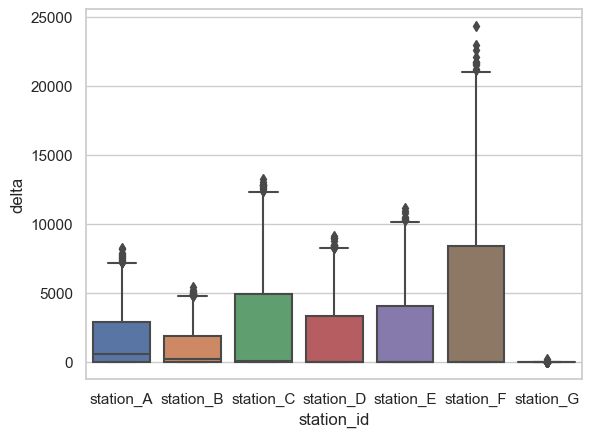

In [155]:
sns.boxplot(x="station_id", y=df.delta.dt.total_seconds(), data=df)

c:\Users\jandi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jandi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jandi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='delta', ylabel='Density'>

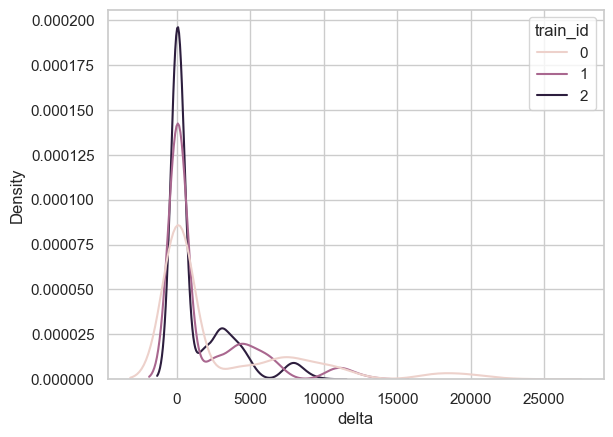

In [160]:
sns.kdeplot(x=df.delta.dt.total_seconds(), hue="train_id", data=df)